In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
headers = ["timestamp", "raw_value", "voltage_level", "battery_fraction", "battery_soc"]
data = pd.read_csv('prototype_data/battery.csv', names=headers)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values(by='timestamp')
data_filtered = data[data['timestamp'].dt.year >= 2024]

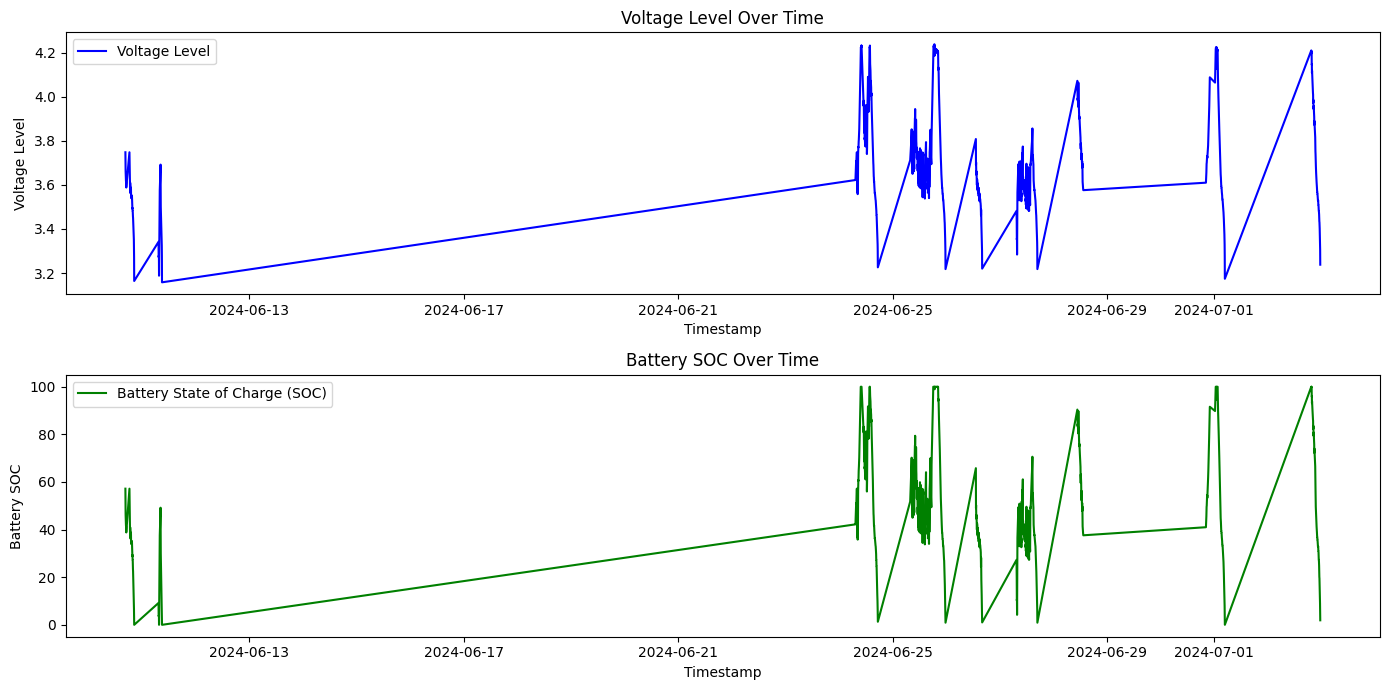

In [18]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data_filtered['timestamp'], data_filtered['voltage_level'], label='Voltage Level', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Voltage Level')
plt.title('Voltage Level Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_filtered['timestamp'], data_filtered['battery_soc'], label='Battery State of Charge (SOC)', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Battery SOC')
plt.title('Battery SOC Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
discharge_cycles = []
cycle_data = []
in_discharge = False
start_time = None

for idx, row in data_filtered.iterrows():
    soc = row['battery_soc']
    if in_discharge:
        current_cycle.append(row)
        if soc >= 100: # If level returns to 100%, discard the data
            in_discharge = False
            start_time = None
            current_cycle = []
    if not in_discharge and soc >= 99:
        in_discharge = True
        start_time = row['timestamp']
        current_cycle = []
        current_cycle.append(row)
    elif in_discharge and soc < 2: # Write time is 3 minutes (180s), so leaving room for potential microcontroller blackout (<3.2V)
        end_time = row['timestamp']
        if start_time is not None:
            discharge_time = end_time - start_time
            discharge_cycles.append(discharge_time)
            cycle_data.append(pd.DataFrame(current_cycle))
        in_discharge = False
        start_time = None

discharge_df = pd.DataFrame(discharge_cycles, columns=['discharge_time'])
display(discharge_df)

discharge_time_avg = discharge_df['discharge_time'].mean()

overview_df = pd.DataFrame({'discharge_time_avg': [discharge_time_avg]})
display(overview_df)

,discharge_time
0,0 days 03:32:44
1,0 days 03:19:22
2,0 days 03:14:08
3,0 days 03:52:03


,discharge_time_avg
0,0 days 03:29:34.250000


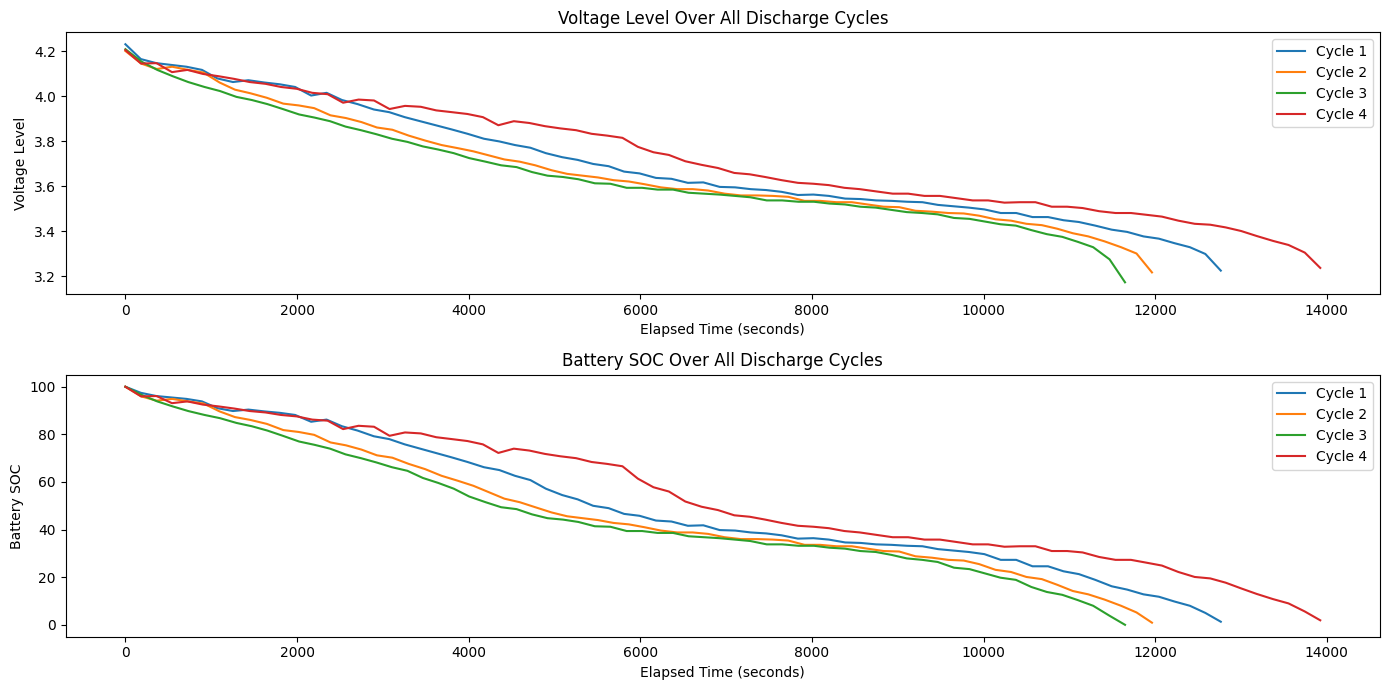

In [73]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
for idx, cycle_df in enumerate(cycle_data):
    cycle_df['elapsed_time'] = (cycle_df['timestamp'] - cycle_df['timestamp'].iloc[0]).dt.total_seconds()
    plt.plot(cycle_df['elapsed_time'], cycle_df['voltage_level'], label=f'Cycle {idx + 1}')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Voltage Level')
plt.title('Voltage Level Over All Discharge Cycles')
plt.legend()

plt.subplot(2, 1, 2)
for idx, cycle_df in enumerate(cycle_data):
    cycle_df['elapsed_time'] = (cycle_df['timestamp'] - cycle_df['timestamp'].iloc[0]).dt.total_seconds()
    plt.plot(cycle_df['elapsed_time'], cycle_df['battery_soc'], label=f'Cycle {idx + 1}')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Battery SOC')
plt.title('Battery SOC Over All Discharge Cycles')
plt.legend()

plt.tight_layout()
plt.show()